In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import load_model

In [3]:
h5file = tensorflow.keras.utils.get_file('/tmp/KDD_model_1.h5',
         'https://raw.githubusercontent.com/nplan-io/kdd2020-calibration/master/tutorial/cifar10_resnet.h5')
multiclass_model = load_model(h5file)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import numpy as np
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)
# Normalize data.
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean from each image
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_val -= x_train_mean
x_test -= x_train_mean

# translate data to categorical
y_train_labels = y_train
y_val_labels = y_val
y_test_labels = y_test

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [9]:
import matplotlib.pyplot as plt
def plot_reliability_diagram(prob_true, prob_pred, model_name, ax=None):
    # Plot the calibration curve for ResNet in comparison with what a perfectly calibrated model would look like
    if ax==None:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.gca()
    else:
        plt.sca(ax)
    
    plt.plot([0, 1], [0, 1], color="#FE4A49", linestyle=":", label="Perfectly calibrated model")
    plt.plot(prob_pred, prob_true, "s-", label=model_name, color="#162B37")

    plt.ylabel("Fraction of positives", fontsize=16)
    plt.xlabel("Mean predicted value", fontsize=16,)

    plt.legend(fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.grid(True, color="#B2C7D9")

    plt.tight_layout()

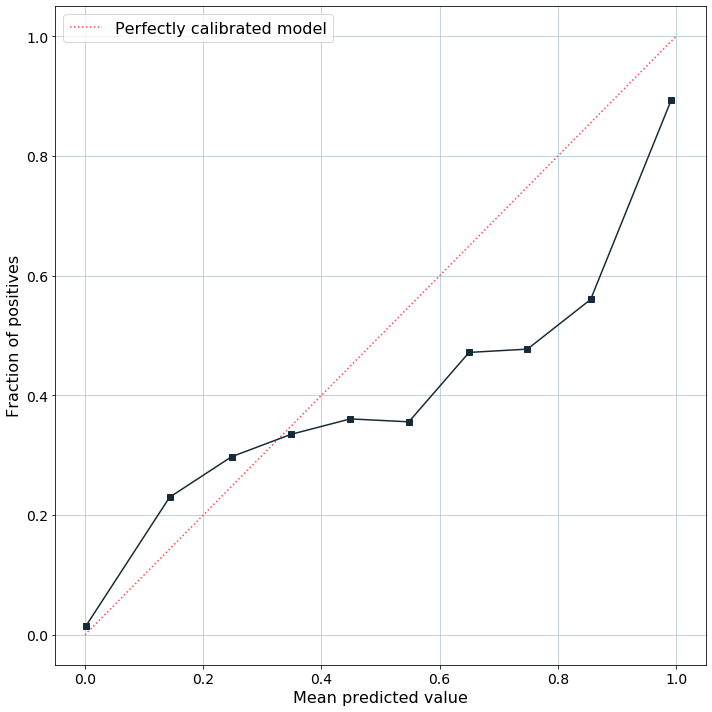

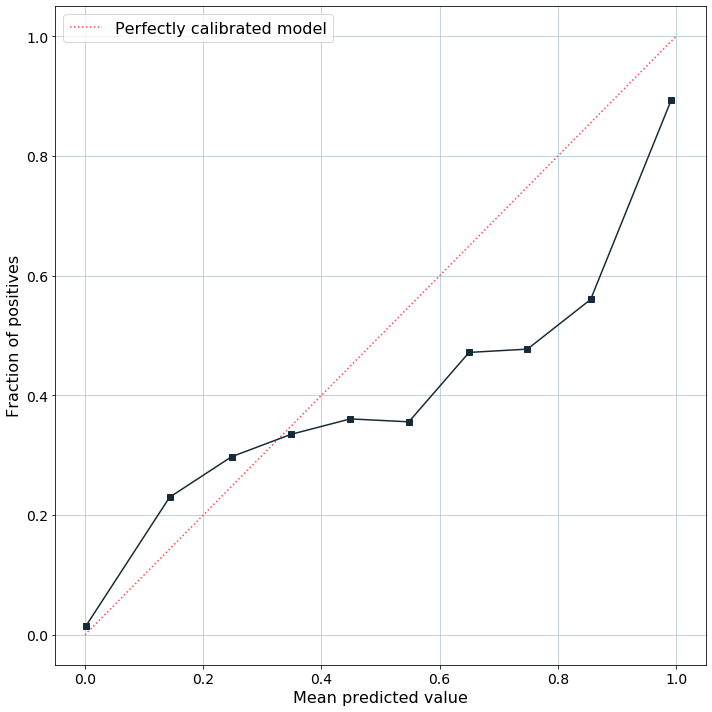

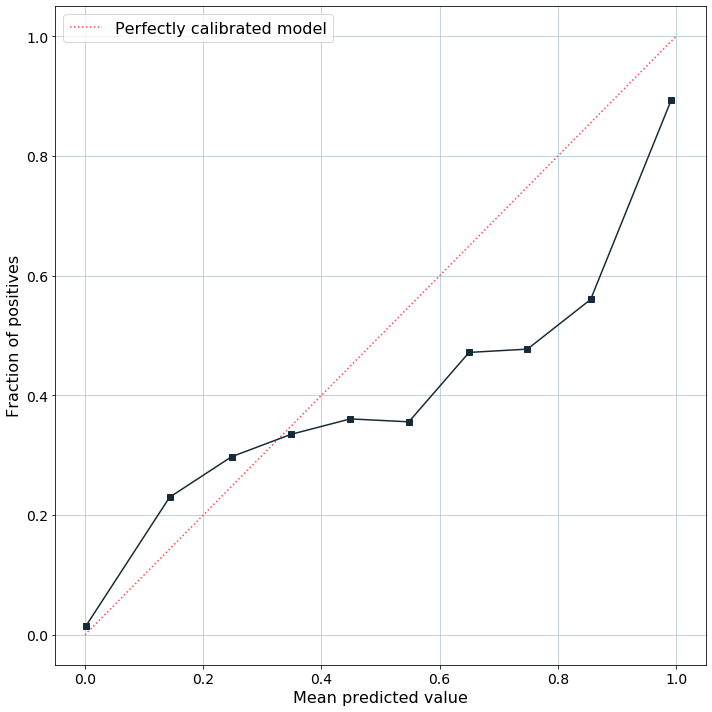

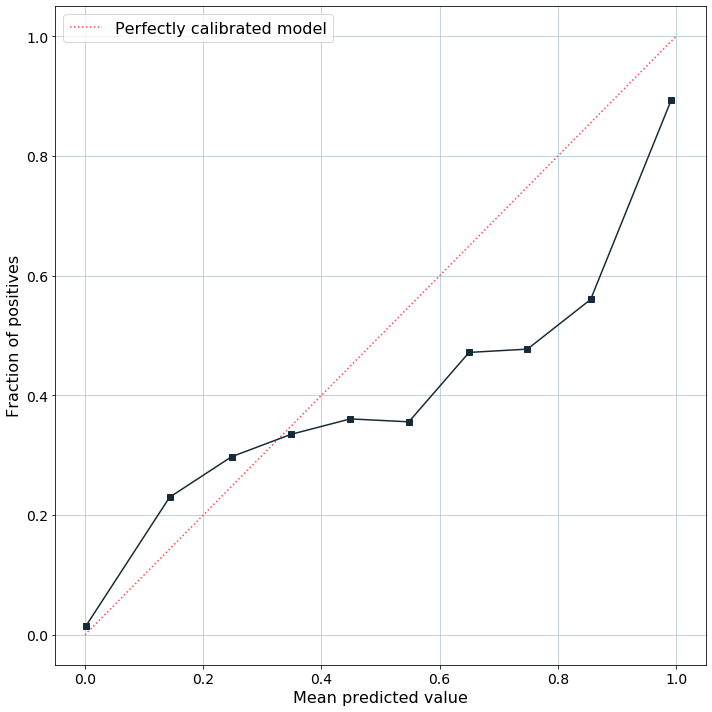

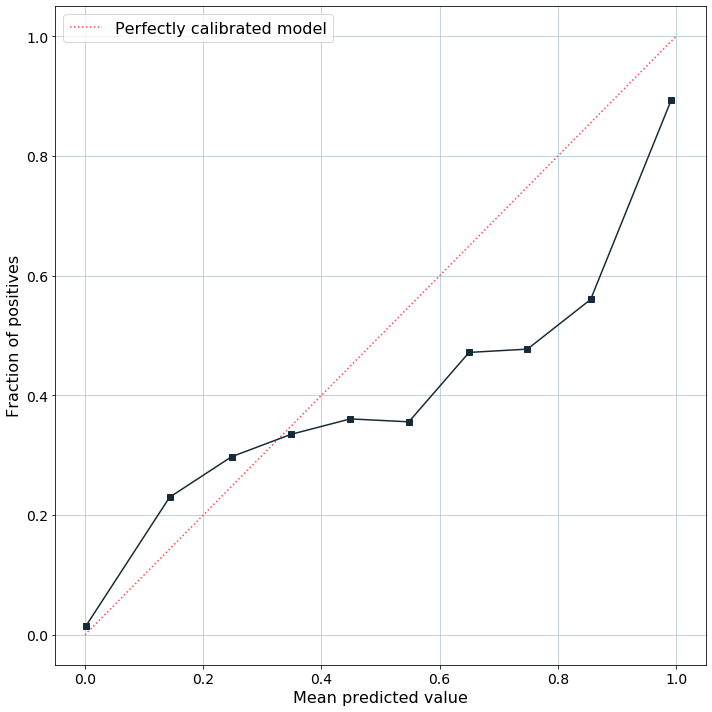

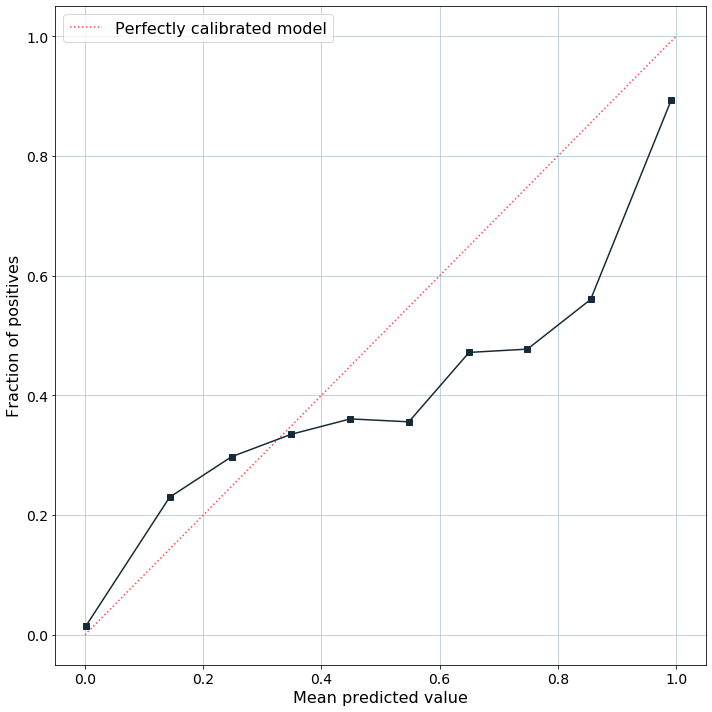

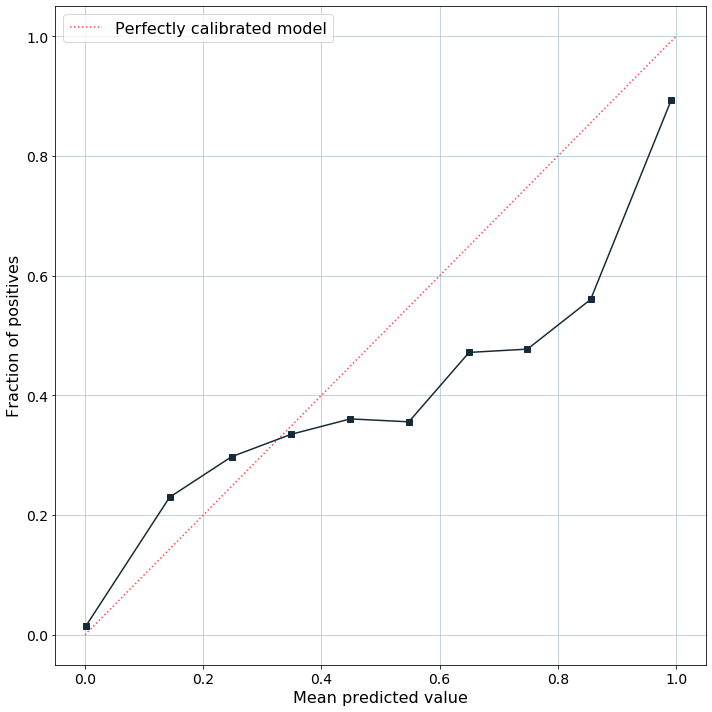

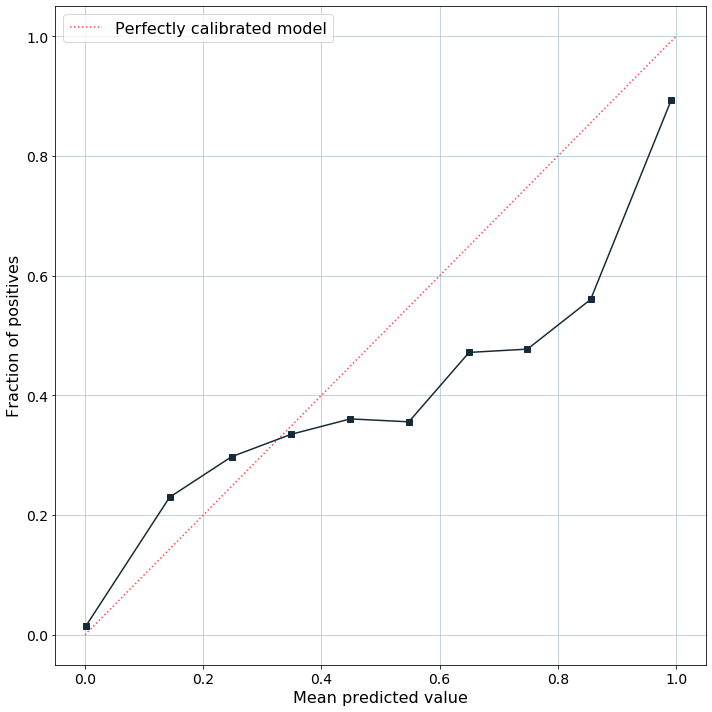

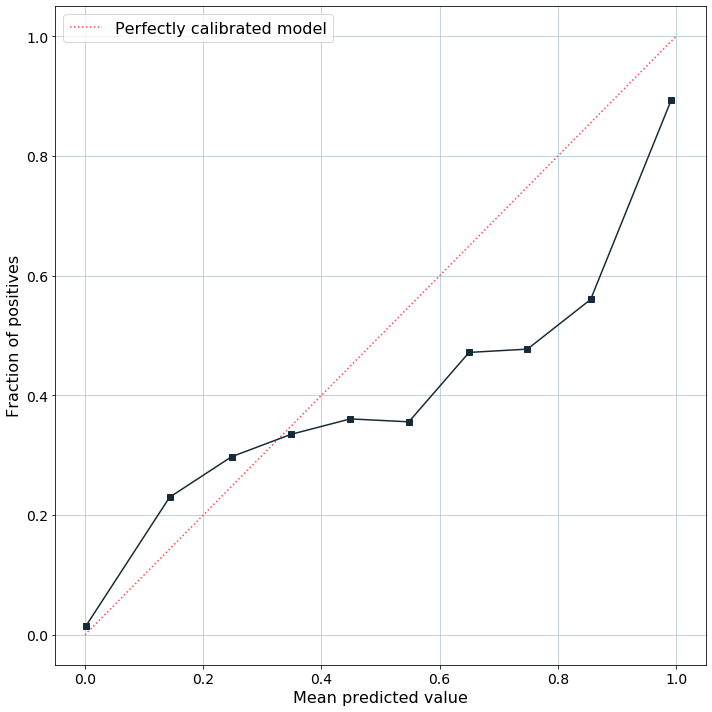

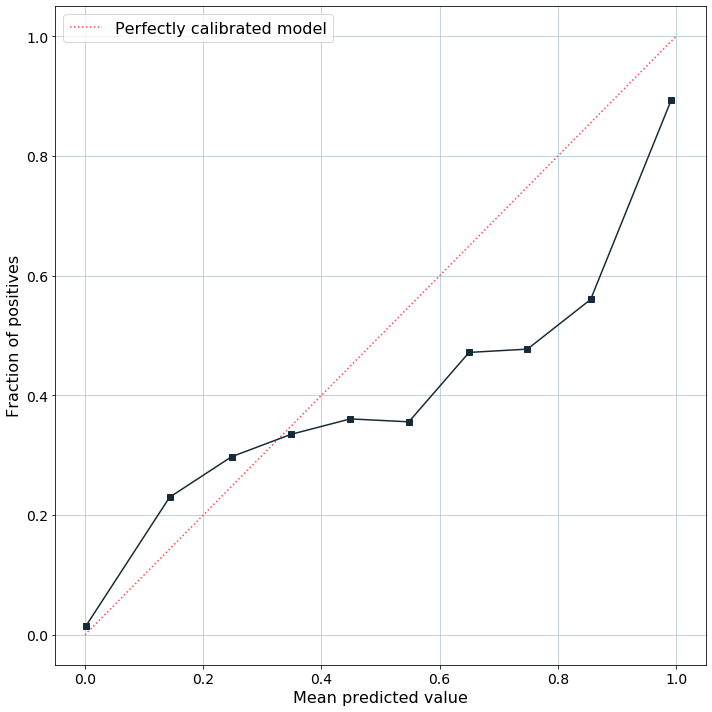

In [57]:
from sklearn.calibration import calibration_curve

y_pred = model.predict(x_test)
prob_true, prob_pred = calibration_curve(y_test.flatten(), y_pred.flatten(), n_bins=10)
plot_reliability_diagram(prob_true, prob_pred, "Resnet (uncalibrated)")

bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]
print(rmsce_calculation_binary(prob_true, prob_pred, bin_sizes))

In [23]:
new_model = model

In [45]:
pre_dense_out = new_model.layers[-2].output
pre_soft_out = tf.keras.layers.Dense(10, activation=None)(pre_dense_out)
new_model = tf.keras.Model(inputs=new_model.input, outputs=pre_soft_out)
new_model.layers[-1].set_weights(model.layers[-1].get_weights())

[array([[-0.03827429,  0.00053536,  0.02354786, ..., -0.10184926,
         -0.01296268, -0.05788943],
        [ 0.00861124, -0.07298811, -0.06827275, ...,  0.09983818,
         -0.03885733,  0.06049917],
        [ 0.06564894,  0.03024454,  0.08653534, ..., -0.10403818,
         -0.08432156,  0.03272909],
        ...,
        [ 0.06864321, -0.05931207,  0.07171469, ..., -0.00712992,
          0.14813443, -0.04268194],
        [ 0.01108313,  0.03065961, -0.08935205, ...,  0.02565586,
          0.01030241,  0.06192446],
        [ 0.05801903,  0.05285829,  0.01837905, ...,  0.0007318 ,
          0.06172966,  0.00918301]], dtype=float32),
 array([ 0.00813145, -0.03716962, -0.01707331,  0.11836018, -0.01819385,
         0.0138504 ,  0.00045021, -0.0346412 , -0.06356826,  0.00101929],
       dtype=float32)]

In [46]:
new_model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
y_logit = new_model.predict(x_val)

In [124]:
from scipy.special import softmax
from sklearn.metrics import log_loss

def scale_fun_ce(x, *args):
    t = x[0]
    y_logit_scaled = y_logit/t
    y_pred_inner = softmax(y_logit_scaled, axis=1)
    return log_loss(y_val, y_pred_inner)

In [125]:
from scipy.optimize import minimize

min_obj = minimize(scale_fun_ce,[10],method='Nelder-Mead',options={'xatol': 1e-13, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.540353
         Iterations: 50
         Function evaluations: 127


 final_simplex: (array([[2.81738281],
       [2.81738281]]), array([0.54035314, 0.54035314]))
           fun: 0.5403531410340543
       message: 'Optimization terminated successfully.'
          nfev: 127
           nit: 50
        status: 0
       success: True
             x: array([2.81738281])

In [122]:
y_logit_test = new_model.predict(x_test)


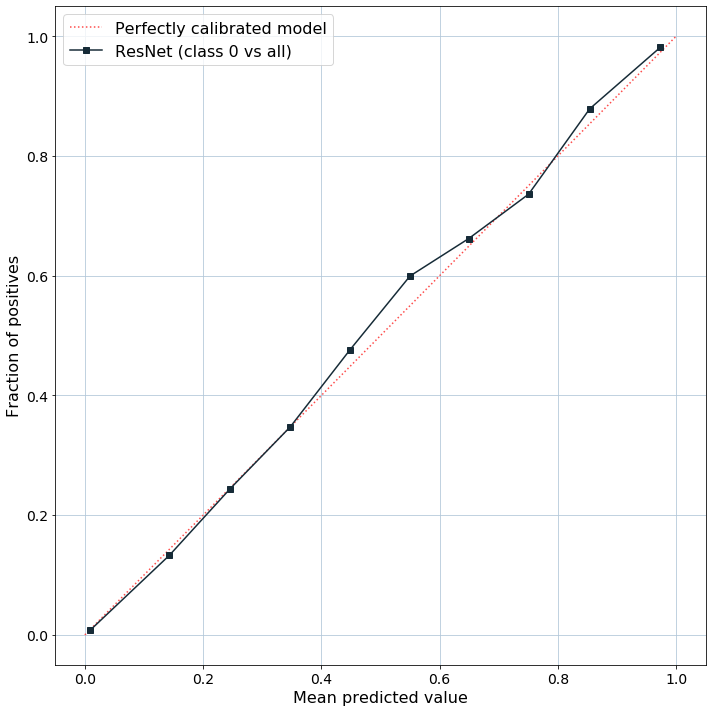

In [123]:
temp_scaled = y_logit_test/min_obj.x[0]
y_pred_test_corr = softmax(temp_scaled, axis=1)
prob_true, prob_pred = calibration_curve(y_test.flatten(), y_pred_test_corr.flatten(), n_bins=10)
bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]
plot_reliability_diagram(prob_true, prob_pred, "Resnet (temp calibrated)")

In [134]:
def rmsce_calculation_binary(prob_true, prob_pred, bin_sizes):
    ### YOUR CODE HERE 
    rmsce = 0
    for m in np.arange(len(bin_sizes)):
        rmsce = rmsce + (bin_sizes[m] / sum(bin_sizes)) * (prob_true[m] - prob_pred[m]) ** 2
    return np.sqrt(rmsce)

0.022311771772448856
0.0045648384139104605


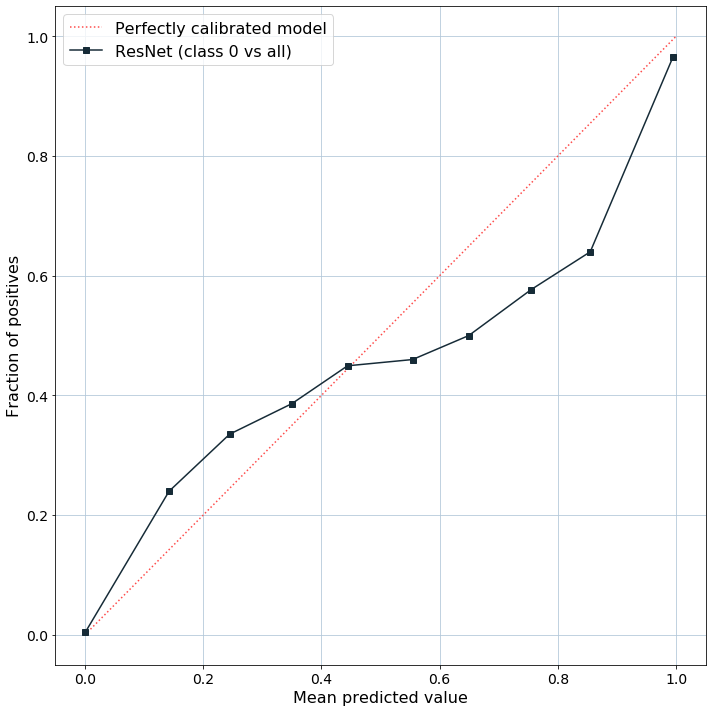

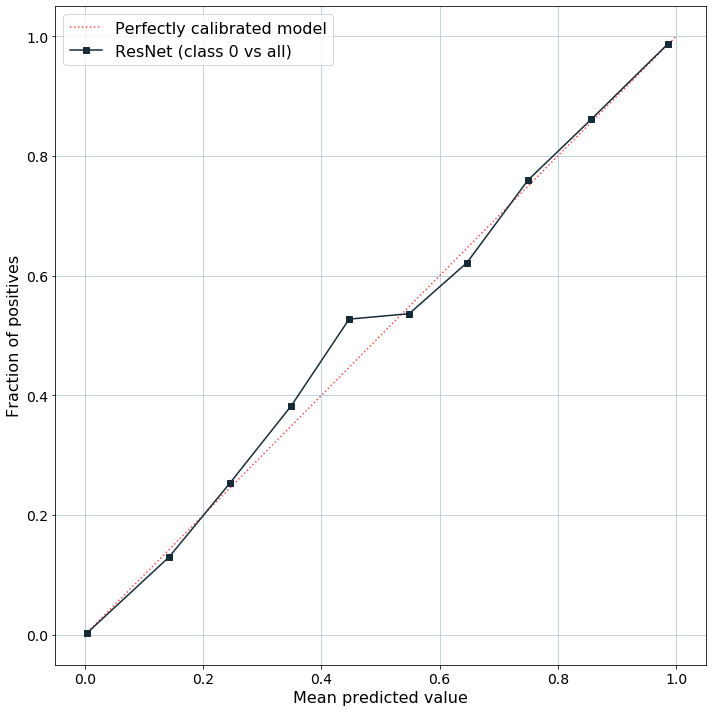

In [139]:

temp_scaled = y_logit_test/min_obj.x[0]
y_pred_test_corr = softmax(temp_scaled, axis=1)
prob_true, prob_pred = calibration_curve(y_test.flatten(), y_pred.flatten(), n_bins=10)
plot_reliability_diagram(prob_true, prob_pred, "ResNet (class 0 vs all)")
bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]
print(rmsce_calculation_binary(prob_true, prob_pred, bin_sizes))

prob_true, prob_pred = calibration_curve(y_test.flatten(), y_pred_test_corr.flatten(), n_bins=10)
plot_reliability_diagram(prob_true, prob_pred, "ResNet (class 0 vs all)")
bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]
print(rmsce_calculation_binary(prob_true, prob_pred, bin_sizes))


